# MK_Analysis
This jupyter notebook is designed to analyze proplatelet production of Megakaryocytes from tiff time-lapses taken by the Incucyte Zoom (10X, 1392x1040px -- 1700 x 1270 um).

This analysis occurs in 3 steps:

1 ilastikProcessing - Unpacks tiff stacks & generates probability masks from phase images through the ilastik project (.ilp) file.


2 Quantification Pipeline - Primary pipeline for proplatelet production analysis. Important output files are listed as follows:
    
    a. 'results_Image.csv' -> raw results
    
    b. 'results_cell/pplt.properties' -> use in CPA to train classifiers
    
    c. 'labels' folder, containing 16-bt labels of proplatelet objects used for the Skeleton pipeline
    
    d. 'overlay' of phase images, labeling megs as red & pplts as green
    
    e. 'Raw.csv','Area.csv','Pplt_Pct.csv' -> Calculated & Formatted Results
    
3 Skeletonization Pipeline - Secondary pipeline for proplatelet structure analysis. Important output files are listed as follows:

In [ ]:
%matplotlib inline
import glob
import h5py
import itertools
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy
import os
import os.path
import pandas
import re
from shutil import copy2
import skimage
import skimage.exposure
import skimage.io
import subprocess
# from tkinter.filedialog import askdirectory
from tqdm._tqdm_notebook import tqdm_notebook

# ilastikProcessing
To effectively use ilastik some formating must be done before and after ilastik processes the images. The input is assumed to be a time-series of images stored in a multi-page TIFF.

# Unpack (or separate) input images into single files.

## Update input image variables
Update the variable *image_directory* with the path to a folder that contains the input images. Update the *regex_image* variable to process only the images that match the regular expression. If the *regex_image* variable is equal to `(.*)\.tif`, then any *.tif* in the folder will be processed.

If a filename matches the *regex_single* regular expression, then it is assumed that this image has already been unpacked. An unpacked single image will have timepoint appended to the end of the file following the pattern `\-\d{4}\.tif`

*path_to_ilastik* is a string with the path to the ilastik software for [running headless](http://ilastik.org/documentation/basics/headless.html).

In [ ]:
image_directory = r"/home/prakrith/Github/2017_06_20_Machlus_megakarocyte_differentiation/test/"
path_to_ilastik = r"/home/prakrith/Applications/ilastik-1.3.0-Linux/run_ilastik.sh"
path_to_project = r"/home/prakrith/Github/2017_06_20_Machlus_megakarocyte_differentiation/ilps/180331_MK_384.ilp"
# path_to_cellprofiler = r"C:\Program Files (x86)\CellProfiler\CellProfiler.exe"
# path_to_cp_pipeline = r"C:\Users\Prakrith\Documents\GitHub\Test\pipelines\180325_MP.cppipe"
regex_image = "(.*)\.tif" #stack
regex_single = ".*\-\d{4}\.tif" #slice
re_image = re.compile(regex_image)
re_single = re.compile(regex_single)

In [ ]:
# image_directory = r"C:\Users\Prakrith\Desktop\test"
# path_to_ilastik = r"C:\Program Files\ilastik-1.3.0b4\run-ilastik.bat"
# path_to_project = r"C:\Users\Prakrith\Documents\GitHub\Test\ilps\180517_Zoom.ilp"
# path_to_cellprofiler = r"C:\Program Files (x86)\CellProfiler\CellProfiler.exe"
# path_to_cp_pipeline = r"C:\Users\Prakrith\Documents\GitHub\Test\pipelines\180512_MP.cppipe"
# regex_image = "(.*)\.tif" #stack
# regex_single = ".*\-\d{4}\.tif" #slice
# re_image = re.compile(regex_image)
# re_single = re.compile(regex_single)

In [ ]:
os.makedirs(os.path.join(image_directory, "single_images"), exist_ok=True)
imdir_single = os.path.join(image_directory,"single_images")
os.makedirs(os.path.join(image_directory, "ilastik"), exist_ok=True)
imdir_ilastik = os.path.join(image_directory,"ilastik")
os.makedirs(os.path.join(image_directory, "output"), exist_ok=True)
output_directory = os.path.join(image_directory,"output")

In [ ]:
# image_directory = r"C:\Users\Prakrith\Desktop\test"
# imdir_single = r"C:\Users\Prakrith\Desktop\test\single_images"
# imdir_ilastik = r"C:\Users\Prakrith\Desktop\test\ilastik"
# output_directory = r"C:\Users\Prakrith\Desktop\test\output"

## Methods to import image metadata
* *is_my_file* will use the regular expression to filter image files to be processed.
* *make_dict* parses a file to be processed and places metadata into a dictionary.

Parse the files to be processed and then place the metadata into a Pandas dataframe.

In [ ]:
def is_my_file(filename, re_image, re_single):
    
    mybool = False
    
    if (    re_image.match(filename) != None 
        and re_single.match(filename) == None
       ):
        
        mybool = True
        
    return mybool


def make_dict(filename, path, re_obj):
    
    my_dict = re_obj.match(filename).groupdict()
    
    my_dict["filename"] = filename
    
    my_dict["path"] = path
    
    return my_dict

In [ ]:
image_files_dict = [make_dict(f, image_directory, re_image) for f in os.listdir(image_directory) if is_my_file(f, re_image, re_single)]
image_df = pandas.DataFrame(image_files_dict)

## Unpack the multi-page TIFF images
For every image, create a single image file for each timepoint. The input images are assumed to be RGB, which has 3 dimensions (length, width, color). The multipage TIFF of RGB images will have 4 dimensions (timepoints, length, width, color). 

*If the upstream workflow changes and the input image format is altered, then the conditional logic below will need to be updated, specifically the logic based on the shape of the input images.*

### Are the images across experiments similar enough to treat equally
One concern is that overfitting from training a classification model either through ilastik or CellProfiler analyst. The training set needs to be representative of the possibility space. This is accomplished by choosing a large enough image set that includes images of all states of interest including undifferentiated and fully differentiated megakaryocytes.

We also want to eliminate noise from known sources of variablity that could potentially weaken the classifier. The primary sources of noise in the images will be non-uniform illumination and differences in exposure. Non-uniform illumination is difficult to correct, because the background is actually in the middle of the intensity range and the signal occupies both high and low intensities.



In [ ]:
#filelist = glob.glob("D:\Prakrith\MK_Differentiation_Kyle\images\single_images\*.tif")

#for f in filelist:
    
#    im = skimage.io.imread(f)
    
#    im2 = skimage.color.rgb2gray(im)
        
#    im2 = skimage.img_as_ubyte(im2)

#    skimage.io.imsave(f, im2)

In [ ]:
# ****DOWNSAMPLE

# def df_stack_image(p):
    
#     im = skimage.io.imread(os.path.join(p["path"], p["filename"]))
    
#     if len(im.shape) < 4:
        
#         retest = re_image.match(p["filename"])

#         retest.group(1)

#         fname = "{0}-{1:04d}.tif".format(retest.group(1), 0)
        
#         im2 = skimage.transform.rescale(im, 0.5)
        
#         im2 = skimage.color.rgb2gray(im2)
        
#         im2 = skimage.img_as_ubyte(im2)
        
#         skimage.io.imsave(os.path.join(p["path"], fname), im2)
        
#     else:
    
#         number_of_timepoints = im.shape[0]

#         for i in range(number_of_timepoints):

#             retest = re_image.match(p["filename"])

#             retest.group(1)

#             fname = "{0}-{1:04d}.tif".format(retest.group(1), i)
            
#             im2 = skimage.transform.rescale(im[i,:,:,:], 0.5)
            
#             im2 = skimage.color.rgb2gray(im2)
        
#             im2 = skimage.img_as_ubyte(im2)
            
#             skimage.io.imsave(os.path.join(p["path"], "single_images", fname), im2)

In [ ]:
def df_stack_image(p):
    
    im = skimage.io.imread(os.path.join(p["path"], p["filename"]))
    
    if len(im.shape) < 4:
        
        retest = re_image.match(p["filename"])

        retest.group(1)

        fname = "{0}-{1:04d}.tif".format(retest.group(1), 0)
        
        im2 = skimage.color.rgb2gray(im)
        
        im2 = skimage.img_as_ubyte(im2)

        skimage.io.imsave(os.path.join(p["path"], fname), im2)
        
    else:
    
        number_of_timepoints = im.shape[0]

        for i in range(number_of_timepoints):

            retest = re_image.match(p["filename"])

            retest.group(1)

            fname = "{0}-{1:04d}.tif".format(retest.group(1), i)
            
            im2 = skimage.color.rgb2gray(im[i,:,:,:])
        
            im2 = skimage.img_as_ubyte(im2)

            skimage.io.imsave(os.path.join(p["path"], "single_images", fname), im2)

In [ ]:
if image_df.empty is False:
    
    # Note that this can fail if the input images aren't in the expected format
    # If you receive an error, double check the format of the input images, e.g. are they RGB?
    tqdm_notebook.pandas(desc="unpack")
    _ = image_df.progress_apply(df_stack_image, axis=1)

else:
    
    print("no images to unpack")

# Run ilastik

Using the single images created earlier, process the images using ilastik. First, create another dataframe with the single image metadata. Note, this has been written for running on Windows.

## Process ilastik output for CellProfiler
ilastik will output and HDF5 file that must be parsed for use as input to CellProfiler. This workflow assumes the default export settings are being used in ilastik. We have observed performance costs when changing the exporting settings to formats beyond the standard ilastik HDF5 file. For example, exporting TIFF images changes the shape of the exported data from yxc (the default) to cyx. This rearrangement will cause downstream errors, because the code as written expects the channel to be the third dimension.

### ilastik stage-2 labels
The project file *Mouse_MK.ilp* has the following labels that are stored in the same order within the HDF5 output.
1. background
1. border_white
1. cell
1. protrusion
1. background_border
1. not_cell

In [ ]:
def is_my_file(filename, re_obj):
    
    mybool = False
    
    if re_obj.match(filename) != None:
        
        mybool = True
        
    return mybool


def make_dict(filename, path, re_obj):
    
    my_dict = re_obj.match(filename).groupdict()
    
    my_dict["filename"] = filename
    
    my_dict["path"] = path
    
    return my_dict

In [ ]:
image_files_dict = [make_dict(f, imdir_single, re_single) for f in os.listdir(imdir_single) if is_my_file(f, re_single)]
image_df = pandas.DataFrame(image_files_dict)

In [ ]:
def df_ilastik(p):
    
    filename = os.path.join(p["path"], p["filename"])
    
    filename_noext = os.path.splitext(p["filename"])[0]
    
    filename_h5 = "{}_Probabilities Stage 2.h5".format(filename_noext)
    
    # Run ilastik using subprocess
    
    process = subprocess.Popen([path_to_ilastik, 
                  "--headless",
                  "--export_source=probabilities stage 2",
                  "--output_format=hdf5",
                  r"--project={}".format(path_to_project),
                  filename
                 ], stdout=subprocess.PIPE)
    
    out, err = process.communicate()
    
    # unpack the HDF5 file
    
    label_list = ["background", "protrusion", "cell_boundary", "cell"]
    
    path_h5 = os.path.join(p["path"], filename_h5)
    
    with h5py.File(path_h5, "r") as ilastik_hdf5:
    
        ilastik_probabilities = ilastik_hdf5["exported_data"].value
    
        for i in range(ilastik_probabilities.shape[2]):
            im = skimage.img_as_uint(ilastik_probabilities[:, :, i])
        
            filename_slice = "{}_{}_prbstg2_{}.png".format(filename_noext, label_list[i], i)
        
            skimage.io.imsave(os.path.join(p["path"], "..", "ilastik", filename_slice), im)
    
    os.remove(path_h5)

In [ ]:
tqdm_notebook.pandas(desc="run ilastik")
_ = image_df.progress_apply(df_ilastik, axis=1)

# Run CellProfiler - Step 1

## Make a filelist
Add the paths to each file that will be processed by CellProfiler into a text file.

In [ ]:
CPA_Rules = r'C:\Users\Prakrith\Desktop\CPTemp_in\fgb_rules_pplt.txt' #directory with location of CellProfiler Analyst Rules
copy2(CPA_Rules, image_directory)

In [ ]:
def sorted_nicely(l): #alphanumeric sorter
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)

In [ ]:
single_list = sorted_nicely(glob.glob(os.path.join(imdir_single,"*.tif")))
ilastik_list = sorted_nicely(glob.glob(os.path.join(imdir_ilastik,"*.png")))
big_list = single_list + ilastik_list
with open(os.path.join(image_directory,"filelist.txt"), 'w') as f:
    for item in big_list:
        f.write("{}\n".format(item))

## Proplatelet Production Pipeline
Use subprocess to run CellProfiler on the images to be processed.

Note, that a model that filters protrusions was trained in CellProfiler Analyst outside of this workflow. The model has to be in the input folder to be found by CellProfiler.

In [ ]:
process = subprocess.Popen([path_to_cellprofiler,
                  "--run-headless",
                  "--pipeline={}".format(path_to_cp_pipeline),
                  "--file-list={}".format(os.path.join(image_directory,"filelist.txt")),
                  "--image-directory={}".format(image_directory),
                  "--output-directory={}".format(output_directory)
                 ], stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
    
out, err = process.communicate()

## Quantify Proplatelet Production
From the csvs generated by CellProfiler, the file 'results_Image' is parsed, & proplatelet production is quantified.

In [ ]:
result = open(os.path.join(output_directory,r'results_Image.csv')); 
header = ["URL_phase","AreaOccupied_AreaOccupied_proplatelets","Count_proplatelets","Count_megs","ImageNumber"]; #"AreaOccupied_AreaOccupied_megs" 
df = pandas.read_csv(result, usecols = header, index_col = False);
df = df.set_index("URL_phase"); #won't allow setting URL_phase as index in read_csv
df = df.reindex(index=sorted_nicely(df.index));

In [ ]:
def f(x):
    try:
        return (((x[2])/(x[1]))*100) #(count_proplatelet/count_meg)*100
    except ZeroDivisionError:
        pass;
    
def g(x):
    return ((x[0] * 2159000) / 1447680); #[(area * total_area_um)/total_area_px]

x = df.apply(f,axis=1);
df['Pct'] = x;
x = df.apply(g,axis=1);
df['Area_um'] = x;
df.to_csv(os.path.join(output_directory,'Raw.csv'));
df.drop(df.columns[[0,1,2]], axis=1, inplace=True);
df = df.set_index("ImageNumber");
df2 = pandas.DataFrame();

In [ ]:
stack_list = sorted_nicely(glob.glob(os.path.join(image_directory,"*.tif")));
t = int(len(single_list)); #total num images
n = int((len(single_list) / len(stack_list))); # slices per stack

for i in range(0,t,n):
    slc = df.iloc[i:i+n];
    slc = slc.reset_index(drop=True);
    df2 = pandas.concat([df2,slc],axis=1,ignore_index=True); #iter df by stack length (n), and concat 

In [ ]:
def res(df,sl,n,name): #dataframe,stack_list,num_timepoints,csv output name
    df.columns = sl;
    df['Timepoint'] = list(range(1,n+1));
    df = df.set_index("Timepoint");
    df.to_csv(os.path.join(output_directory,name)); #function adds headers to columns, fixes index, and creates final csv
    
a = df2.loc[:,1::2];
res(a,stack_list,n,r'Area.csv');
p = df2.loc[:,::2];
res(p,stack_list,n,r'PPlt_Pct.csv');

# Run CellProfiler - Step 2

## Make Skeleton filelist
Include the paths to each label file that will also be processed by CellProfiler into a text file.

In [ ]:
path_to_sk_pipeline = r"C:\Users\Prakrith\Documents\GitHub\Test\pipelines\Kyle_Skel.cppipe" #second pipeline

In [521]:
os.makedirs(os.path.join(image_directory, "skeleton"), exist_ok=True)
skeleton_directory = os.path.join(image_directory,"skeleton");

In [433]:
os.makedirs(os.path.join(image_directory, "skeleton2"), exist_ok=True)
skeleton_directory = os.path.join(image_directory,"skeleton2");

In [522]:
imdir_label = os.path.join(output_directory,"labels");
label_list = sorted_nicely(glob.glob(os.path.join(imdir_label,"*.tiff")));
skel_list = single_list + label_list
with open(os.path.join(image_directory,"filelist2.txt"), 'w') as f:
    for item in skel_list:
        f.write("{}\n".format(item))

## Skeleton Pipeline
Use subprocess to run CellProfiler on the images/labels to be processed.

In [ ]:
process = subprocess.Popen([path_to_cellprofiler,
                  "--run-headless",
                  "--pipeline={}".format(path_to_sk_pipeline),
                  "--file-list={}".format(os.path.join(image_directory,"filelist2.txt")),
                  "--image-directory={}".format(image_directory),
                  "--output-directory={}".format(skeleton_directory)
                 ], stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)

out, err = process.communicate()

## Measure Proplatelet Phenotypes
Proplatelet structures are measured from the following csvs generated by the Skeleton pipeline.

    1 results_MaskedProtrusions
    2 results_prot_seed (pplt seed points)
    3 results_ppltobj

In [523]:
def skcsv(sk_dir,csv,header,columns):
    csv = open(os.path.join(sk_dir,csv));
    df = pandas.read_csv(csv, usecols = header, index_col = False);
    df.columns = columns;
    return df;

In [524]:
mp_head = ["Location_Center_X","Location_Center_Y","Parent_ppltobj"]; #MaskedProtrusions; "Parent_protrusions"
mp_columns = ["Masked_Protrusion_X","Masked_Protrusion_Y","Parent_ppltobj"];
mp_df = skcsv(skeleton_directory,'results_MaskedProtrusions.csv',mp_head,mp_columns);

In [525]:
ps_head = ['ImageNumber', 'ObjectNumber', 'Metadata_time', 'Location_Center_X', #protrusion_seeds
       'Location_Center_Y',
       'ObjectSkeleton_NumberBranchEnds_MaskedProtrusionsImage',
       'ObjectSkeleton_NumberNonTrunkBranches_MaskedProtrusionsImage',
       'ObjectSkeleton_NumberTrunks_MaskedProtrusionsImage',
       'ObjectSkeleton_TotalObjectSkeletonLength_MaskedProtrusionsImage'];

ps_columns = ['ImageNumber', 'ObjectNumber', 'Timepoint',
              'ProtrusionSeed_X', 'ProtrusionSeed_Y',
              'NumEndpointsBlue', 'NumBranchGreen', 'NumTrunksRed',
              'TotalObjLength'];

ps_df = skcsv(skeleton_directory,'results_prot_seed.csv',ps_head,ps_columns);

def i(x):
    return (x[5] + x[6] + x[7]);

x = ps_df.apply(i,axis=1);
ps_df['TotalNodes'] = x;
ps_df = ps_df.add(mp_df,axis='columns',fill_value=0);
ps_df.to_csv(os.path.join(skeleton_directory,'Raw_Skel.csv'));

In [526]:
po_head = ['ImageNumber', 'ObjectNumber', 'Metadata_time',     #ppltobj
       'Children_MaskedProtrusions_Count', 'Location_Center_X',
       'Location_Center_Y', 'Mean_MaskedProtrusions_Location_Center_X',
       'Mean_MaskedProtrusions_Location_Center_Y',
       'Mean_MaskedProtrusions_Number_Object_Number'];

po_columns = ['ImageNumber', 'ObjectNumber', 'Timepoint', 
              'MaskedProtrusionCount', 'PpltObj_X', 'PpltObj_Y', 
              'MeanPpltObj_X', 'MeanPpltObj_Y', 
              'MeanMaskedProtrusionsNumber'];

po_df = skcsv(skeleton_directory,'results_ppltobj.csv',po_head,po_columns);
po_df.to_csv(os.path.join(skeleton_directory,'PpltObj.csv'));

# NetworkX

This python program is used to construct graphs to model proplatelet structures from the edges & vertices csvs.

- The edge list is a simple data structure that you'll use to create the graph. Each row represents a single edge of the graph with some edge attributes.
- Node lists are usually optional in networkx and other graph libraries when edge lists are provided because the node names are provided in the edge list's first two columns. However, in this case, there are some node attributes that we'd like to add.

In [689]:
vertices_csv = open(os.path.join(skeleton_directory,r'vertices.csv'));
v_df = pandas.read_csv(vertices_csv);
v_df.columns = ['image_number', 'vertex_number','y','x','labels','kind'];#rename i,j to y,x
v_df = v_df[['vertex_number', 'x','y','labels', 'kind','image_number']];#swap y,x to x,y in vertices_csv
v_df.columns = ['Node','x','y','Labels','Kind','ImageNumber'];#rename i,j to y,x
v_df.to_csv(os.path.join(skeleton_directory,'Vert.csv')); #nodelist (optional w/ edgelist, adds more hashable attributes)

In [690]:
edges_csv = open(os.path.join(skeleton_directory,r'edges.csv'));
header = ['image_number', 'v1', 'v2', 'length'];
e_df = pandas.read_csv(edges_csv, usecols = header, index_col = False);
e_df.columns = ['ImageNumber', 'Node_1', 'Node_2', 'Distance']; #
e_df = e_df[['Node_1','Node_2','Distance','ImageNumber']];
e_df.to_csv(os.path.join(skeleton_directory,'Edge.csv')); #edgelist

In [691]:
im=6
obj=1

In [692]:
def imslc(df,im): #edgelist/nodelist df,imagenum; slice edgelist by imagenumber
    df = df[df["ImageNumber"]==im]
#     del df['ImageNumber']
    return df;

edgelist = imslc(e_df,im)
nodelist = imslc(v_df,im) #Use these lists for all ppltobjs in image

In [693]:
def labelList(df,im,obj): #df=ps_df,imnum,objnum
    df = df[df["ImageNumber"]==im]
    df = df[df['Parent_ppltobj']==obj]
    return list(df["ObjectNumber"].unique());

l = labelList(ps_df,im,obj);
a = [int(i) for i in l];
a[:] = [x - 1 for x in a];
nodelist = nodelist[nodelist.Labels.isin(a)];
b = list(nodelist["Node"]);
# b[:] = [x - 1 for x in b]
edgelist = edgelist[edgelist.Node_2.isin(b)]; #Slice the edgelist further by label -> 1 ppltobj per graph

In [694]:
def skelPlot(edge,node): #edgelist,nodelist
#     g = nx.DiGraph();
    g = nx.Graph();
    
    # Add edges and attributes
    for i, elrow in edge.iterrows():
        g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())
    
    # Add node attributes
    for i, nlrow in nodelist.iterrows():
        try:
            g.node[nlrow['Node']].update(nlrow[1:].to_dict())
        except KeyError:
            pass
        
    # Define node positions dict for plotting    
    node_positions = {node[0]: (node[1]['x'], -node[1]['y']) for node in g.nodes(data=True)}
    
    color_map = []
    for node in g:
        if g.node[node]['Kind'] == 'E': #Endpoints changed from blue to red
            color_map.append('red')
#         elif g.node[node]['Kind'] == 'B': 
#             color_map.append('green')
        else:
            color_map.append('black') #Make all nodes except endpoints black
                
    plt.figure(figsize=(8, 12))
    nx.draw(g, pos=node_positions,node_size=7, node_color = color_map)#,with_labels = True)
    plt.title("Test", size=15)
    plt.show()
    return g;

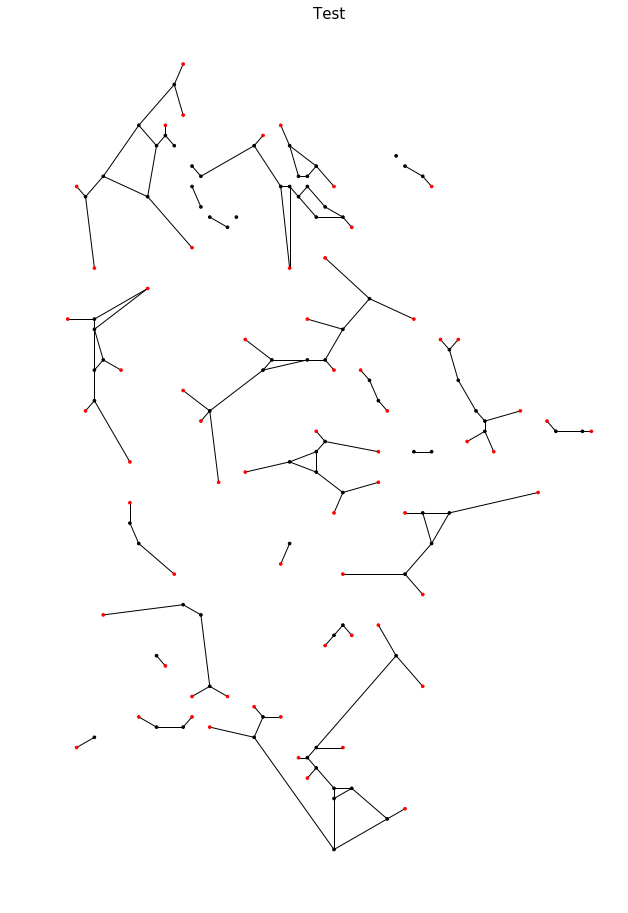

In [695]:
g = skelPlot(edgelist,nodelist); #Are trunk connection distances=3?

In [697]:
sp=nx.all_pairs_dijkstra_path_length(g) 
for n in sp:
     print(n[1]) 

{1: 0, 2: 1, 3: 2, 4: 2, 9: 3, 17: 3, 7: 4, 30: 4, 29: 4, 5: 5, 10: 5, 40: 5, 22: 5, 42: 5}
{2: 0, 1: 1, 3: 1, 4: 1, 9: 2, 17: 2, 7: 3, 30: 3, 29: 3, 5: 4, 10: 4, 40: 4, 22: 4, 42: 4}
{3: 0, 2: 1, 1: 2, 4: 2, 9: 3, 17: 3, 7: 4, 30: 4, 29: 4, 5: 5, 10: 5, 40: 5, 22: 5, 42: 5}
{4: 0, 2: 1, 9: 1, 17: 1, 1: 2, 3: 2, 7: 2, 30: 2, 29: 2, 5: 3, 10: 3, 40: 3, 22: 3, 42: 3}
{5: 0, 7: 1, 9: 2, 10: 2, 4: 3, 30: 3, 2: 4, 17: 4, 40: 4, 1: 5, 3: 5, 29: 5, 22: 6, 42: 6}
{7: 0, 5: 1, 9: 1, 10: 1, 4: 2, 30: 2, 2: 3, 17: 3, 40: 3, 1: 4, 3: 4, 29: 4, 22: 5, 42: 5}
{9: 0, 4: 1, 7: 1, 30: 1, 2: 2, 17: 2, 5: 2, 10: 2, 40: 2, 1: 3, 3: 3, 29: 3, 22: 4, 42: 4}
{10: 0, 7: 1, 5: 2, 9: 2, 4: 3, 30: 3, 2: 4, 17: 4, 40: 4, 1: 5, 3: 5, 29: 5, 22: 6, 42: 6}
{8: 0, 11: 1, 18: 2, 24: 2, 14: 3, 25: 3, 43: 3, 31: 4, 26: 5, 36: 5, 33: 6, 37: 6, 39: 7}
{11: 0, 8: 1, 18: 1, 24: 1, 14: 2, 25: 2, 43: 2, 31: 3, 26: 4, 36: 4, 33: 5, 37: 5, 39: 6}
{6: 0, 12: 1, 15: 2, 19: 2, 20: 3, 27: 3}
{12: 0, 6: 1, 15: 1, 19: 1, 20: 2, 27: 2

In [ ]:
paths = sorted(nx.all_shortest_paths(g, x, y))

for path in paths:
    total_length = 0
    for i in range(len(path)-1):
        source, target = path[i], path[i+1]
        edge = g[source][target]
        length = edge['length']
        total_length += length
    print('{}: {}'.format(path, total_length))

In [ ]:
spl=nx.all_pairs_dijkstra_path_length(g)
for n in spl:
     print(n[1]) 

In [ ]:
po_csv = open(os.path.join(skeleton_directory,r'PpltObj.csv'));
header = ["ImageNumber",'ObjectNumber', "PpltObj_X", "PpltObj_Y"];
po_df = pandas.read_csv(po_csv, usecols = header, index_col = False);

def centroid(po,i): #ppltobj csv,image #
    x = po[po["ImageNumber"] == i]; #slice ppltobj.csv by ImageNumber
    del x["ImageNumber"];
    x = x.set_index('ObjectNumber').T.to_dict('list')
    return x;

centroid(po_df,6) #x[1] x[1][0] ->dict slicing

In [ ]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances